# MSL Dataset

In [50]:
import pandas as pd
import numpy as np

# Wczytanie metadanych
metadata = pd.read_csv("labeled_anomalies.csv")
msl_channels = metadata[metadata['spacecraft'] == 'MSL']['chan_id'].tolist()

## Przygotowanie danych

In [51]:
msl_train_data = {}
for channel in msl_channels:
    try:
        data = np.load(f"data/train/{channel}.npy")
        msl_train_data[channel] = data
    except FileNotFoundError:
        print(f"{channel}: brak danych")
    
msl_test_data = {}
for channel in msl_channels:
    try:
        data = np.load(f"data/test/{channel}.npy")
        msl_test_data[channel] = data
    except FileNotFoundError:
        print(f"{channel}: brak danych")

del data
del channel

## Działanie na danych MSL

In [52]:
# Kształt danych MSL
msl_train_shapes = {channel: msl_train_data[channel].shape for channel in msl_train_data}
print(msl_train_shapes)
del msl_train_shapes

msl_test_shapes = {channel: msl_test_data[channel].shape for channel in msl_test_data}
print(msl_test_shapes)
del msl_test_shapes

{'M-6': (1565, 55), 'M-1': (2209, 55), 'M-2': (2208, 55), 'S-2': (926, 55), 'P-10': (4308, 55), 'T-4': (2272, 55), 'T-5': (2272, 55), 'F-7': (2511, 55), 'M-3': (2037, 55), 'M-4': (2076, 55), 'M-5': (2032, 55), 'P-15': (3682, 55), 'C-1': (2158, 55), 'C-2': (764, 55), 'T-12': (1145, 55), 'T-13': (1145, 55), 'F-4': (2244, 55), 'F-5': (2598, 55), 'D-14': (3675, 55), 'T-9': (439, 55), 'P-14': (2880, 55), 'T-8': (748, 55), 'P-11': (3969, 55), 'D-15': (2074, 55), 'D-16': (1451, 55), 'M-7': (1587, 55), 'F-8': (3342, 55)}
{'M-6': (2049, 55), 'M-1': (2277, 55), 'M-2': (2277, 55), 'S-2': (1827, 55), 'P-10': (6100, 55), 'T-4': (2217, 55), 'T-5': (2218, 55), 'F-7': (5054, 55), 'M-3': (2127, 55), 'M-4': (2038, 55), 'M-5': (2303, 55), 'P-15': (2856, 55), 'C-1': (2264, 55), 'C-2': (2051, 55), 'T-12': (2430, 55), 'T-13': (2430, 55), 'F-4': (3422, 55), 'F-5': (3922, 55), 'D-14': (2625, 55), 'T-9': (1096, 55), 'P-14': (6100, 55), 'T-8': (1519, 55), 'P-11': (3535, 55), 'D-15': (2158, 55), 'D-16': (2191, 5

In [53]:
import torch

if torch.cuda.is_available():
    print("GPU is available :)")
    device = torch.device("cuda")
else:
    print("GPU is NOT available, using CPU. :(")
    device = torch.device("cpu")

GPU is available :)


In [54]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

class UniversalAE(nn.Module):
    def __init__(self, input_dim):
        super(UniversalAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [59]:
from sklearn.preprocessing import MinMaxScaler

# Wybór czujnika
sensor_name = msl_channels[5]
print(f"Wybrano czujnik: {sensor_name}")

sensor_train_data = msl_train_data[sensor_name]
input_dim = sensor_train_data.shape[1]  

scaler = MinMaxScaler()
arr_norm = scaler.fit_transform(sensor_train_data)

model = UniversalAE(input_dim).to(device)


Wybrano czujnik: T-4


## Nauka na danych treningowych

In [60]:
from torch.utils.data import DataLoader, TensorDataset

epochs = 400
batch_size = 64

X_train = torch.tensor(arr_norm, dtype=torch.float32).to(device)
train_dataset = TensorDataset(X_train)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)

model = UniversalAE(input_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        x_batch = batch[0]
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, x_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.6f}")



Epoch 1/400, Loss: 0.007166
Epoch 1/400, Loss: 0.014281
Epoch 1/400, Loss: 0.021357
Epoch 1/400, Loss: 0.028391
Epoch 1/400, Loss: 0.035377
Epoch 1/400, Loss: 0.042316
Epoch 1/400, Loss: 0.049210
Epoch 1/400, Loss: 0.056055
Epoch 1/400, Loss: 0.062851
Epoch 1/400, Loss: 0.069604
Epoch 1/400, Loss: 0.076300
Epoch 1/400, Loss: 0.082946
Epoch 1/400, Loss: 0.089534
Epoch 1/400, Loss: 0.096069
Epoch 1/400, Loss: 0.102539
Epoch 1/400, Loss: 0.108942
Epoch 1/400, Loss: 0.115279
Epoch 1/400, Loss: 0.121545
Epoch 1/400, Loss: 0.127728
Epoch 1/400, Loss: 0.133833
Epoch 1/400, Loss: 0.139852
Epoch 1/400, Loss: 0.145802
Epoch 1/400, Loss: 0.151605
Epoch 1/400, Loss: 0.157331
Epoch 1/400, Loss: 0.162943
Epoch 1/400, Loss: 0.168404
Epoch 1/400, Loss: 0.173763
Epoch 1/400, Loss: 0.178991
Epoch 1/400, Loss: 0.184062
Epoch 1/400, Loss: 0.188995
Epoch 1/400, Loss: 0.193791
Epoch 1/400, Loss: 0.198381
Epoch 1/400, Loss: 0.202809
Epoch 1/400, Loss: 0.207038
Epoch 1/400, Loss: 0.211083
Epoch 1/400, Loss: 0

# Autoencoder na danych testowych

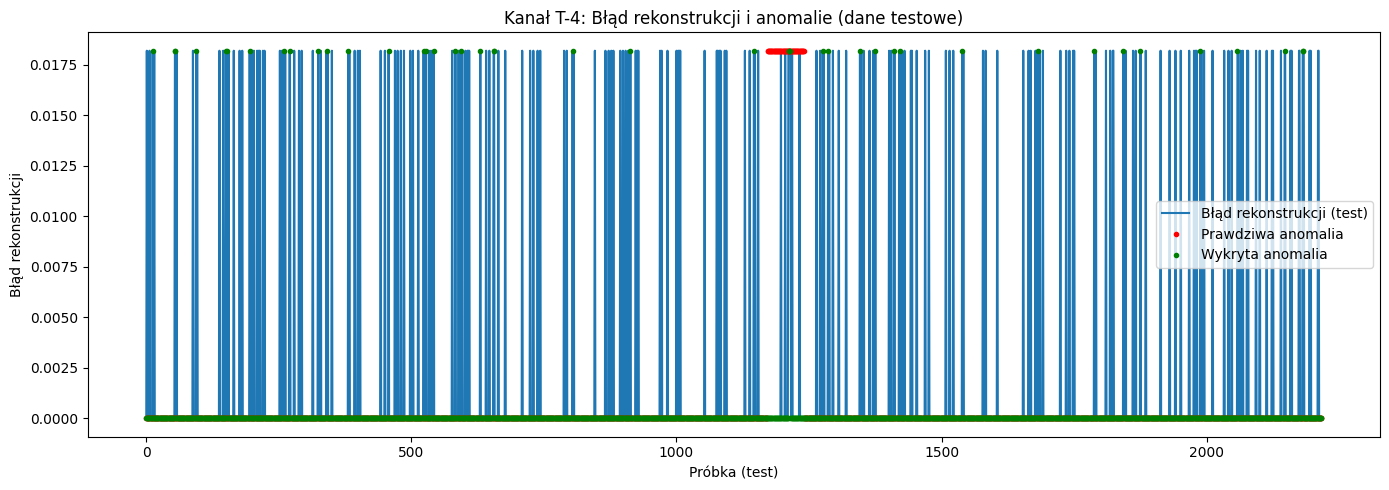

Confusion matrix (test):
[[2108   40]
 [  66    3]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.97      0.98      0.98      2148
     Anomaly       0.07      0.04      0.05        69

    accuracy                           0.95      2217
   macro avg       0.52      0.51      0.51      2217
weighted avg       0.94      0.95      0.95      2217

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1172, 1240]: WYKRYTA


In [61]:
# Normalizacja oraz wczytanie danych testowych 
sensor_test_data = msl_test_data[sensor_name]
arr_test_norm = scaler.transform(sensor_test_data)
X_test = torch.tensor(arr_test_norm, dtype=torch.float32).to(device)

# Rekonstrukcja i obliczenie błędu rekonstrukcji na danych testowych
model.eval()
with torch.no_grad():
    recon = model(X_test).cpu().numpy()
recon_error = np.mean((arr_test_norm - recon) ** 2, axis=1)   

# Wykrywanie anomalii na danych testowych
threshold = np.percentile(recon_error, 98)
predicted_anomaly = (recon_error > threshold).astype(int)

# Prawdziwe anomalie z labeled_anomalies.csv dla testowych indeksów
anomaly_row = metadata[metadata['chan_id'] == sensor_name]
anomaly_sequences = []
if not anomaly_row.empty:
    anomaly_sequences = eval(anomaly_row.iloc[0]['anomaly_sequences'])

true_anomaly = np.zeros(len(recon_error), dtype=int)   
for seq in anomaly_sequences:
    start, end = seq
    true_anomaly[start:min(end+1, len(true_anomaly))] = 1

# Wizualizacja wyników na danych testowych
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

plt.figure(figsize=(14, 5))
plt.plot(recon_error, label="Błąd rekonstrukcji (test)")
plt.plot(true_anomaly * np.max(recon_error), 'r.', label="Prawdziwa anomalia")
plt.plot(predicted_anomaly * np.max(recon_error), 'g.', label="Wykryta anomalia")
plt.title(f"Kanał {sensor_name}: Błąd rekonstrukcji i anomalie (dane testowe)")
plt.xlabel("Próbka (test)")
plt.ylabel("Błąd rekonstrukcji")
plt.legend()
plt.tight_layout()
plt.show()

print("Confusion matrix (test):")
print(confusion_matrix(true_anomaly, predicted_anomaly))
print("\nClassification report (test):")
print(classification_report(true_anomaly, predicted_anomaly, target_names=["Normal", "Anomaly"]))

# Sprawdzenie czy wykryto PRZYNAJMNIEJ JEDNĄ próbkę z każdej zdefiniowanej anomalii
detected_ranges = [] 
remaining_sequences = anomaly_sequences.copy()

for seq in anomaly_sequences:
    start, end = seq
    if np.any(predicted_anomaly[start:min(end+1, len(predicted_anomaly))] == 1):
        detected_ranges.append(seq)

# Wypisanie wyników
print("Wynik sprawdzania anomalii względem metadanych:")
for seq in anomaly_sequences:
    if seq in detected_ranges:
        print(f"Anomalia {seq}: WYKRYTA")
    else:
        print(f"Anomalia {seq}: NIEWYKRYTA")


# Dla wszystkich czujników MSL


Czujnik: M-6
Epoch 1/100, Loss: 0.233233
Epoch 21/100, Loss: 0.002895
Epoch 41/100, Loss: 0.002823
Epoch 61/100, Loss: 0.001586
Epoch 81/100, Loss: 0.001571


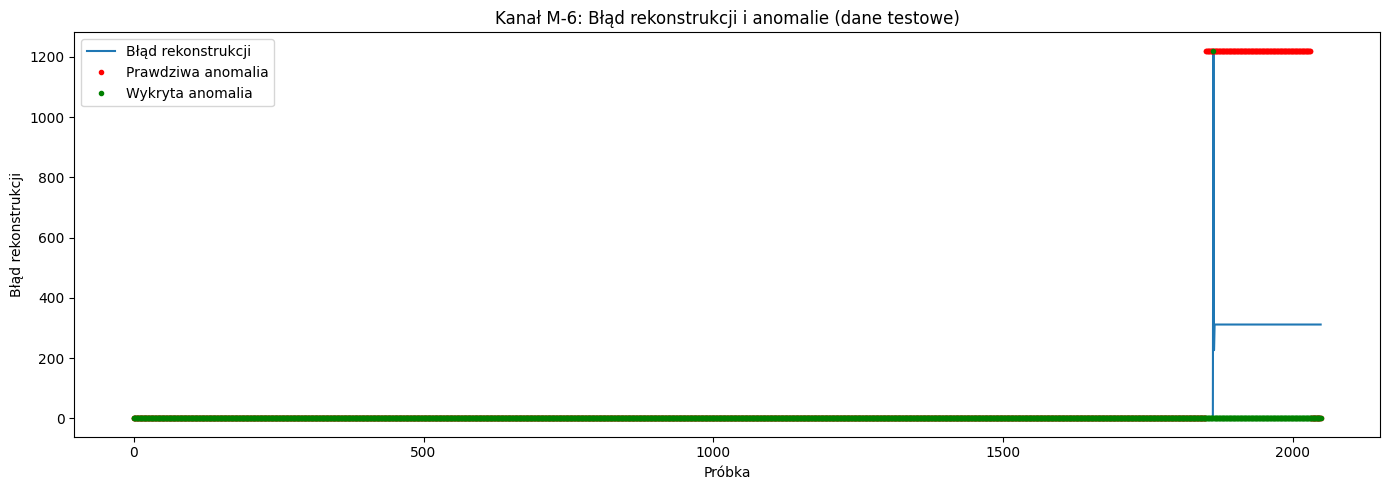

Confusion matrix (test):
[[1868    0]
 [ 180    1]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.91      1.00      0.95      1868
     Anomaly       1.00      0.01      0.01       181

    accuracy                           0.91      2049
   macro avg       0.96      0.50      0.48      2049
weighted avg       0.92      0.91      0.87      2049

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1850, 2030]: WYKRYTA

Czujnik: M-1
Epoch 1/100, Loss: 0.213429
Epoch 21/100, Loss: 0.000767
Epoch 41/100, Loss: 0.000627
Epoch 61/100, Loss: 0.000494
Epoch 81/100, Loss: 0.000478


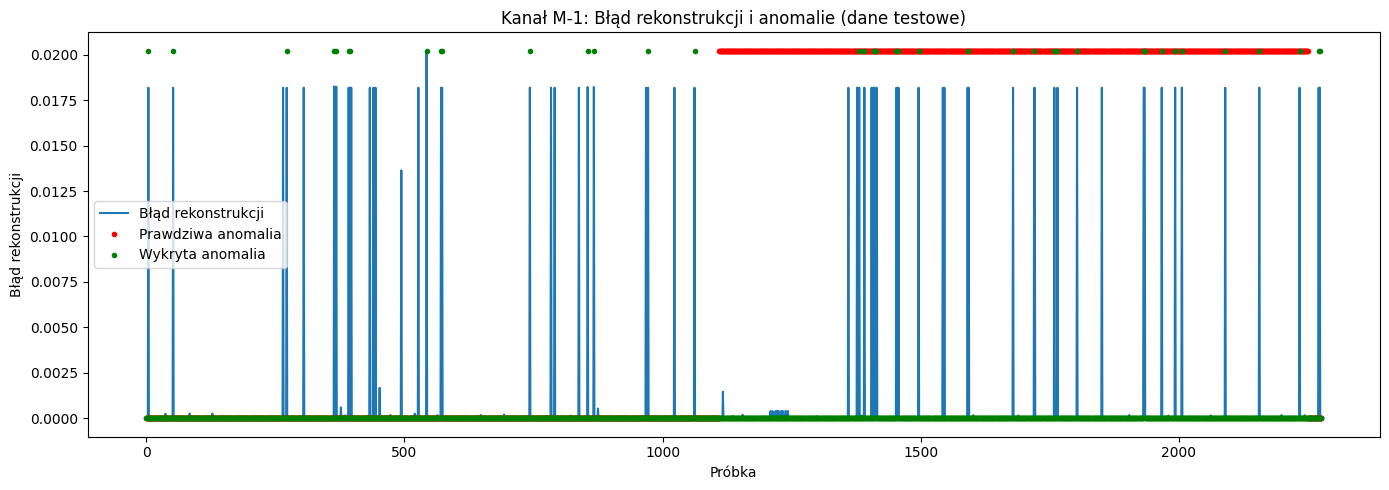

Confusion matrix (test):
[[1119   17]
 [1118   23]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.50      0.99      0.66      1136
     Anomaly       0.57      0.02      0.04      1141

    accuracy                           0.50      2277
   macro avg       0.54      0.50      0.35      2277
weighted avg       0.54      0.50      0.35      2277

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1110, 2250]: WYKRYTA

Czujnik: M-2
Epoch 1/100, Loss: 0.219205
Epoch 21/100, Loss: 0.001317
Epoch 41/100, Loss: 0.000637
Epoch 61/100, Loss: 0.000368
Epoch 81/100, Loss: 0.000366


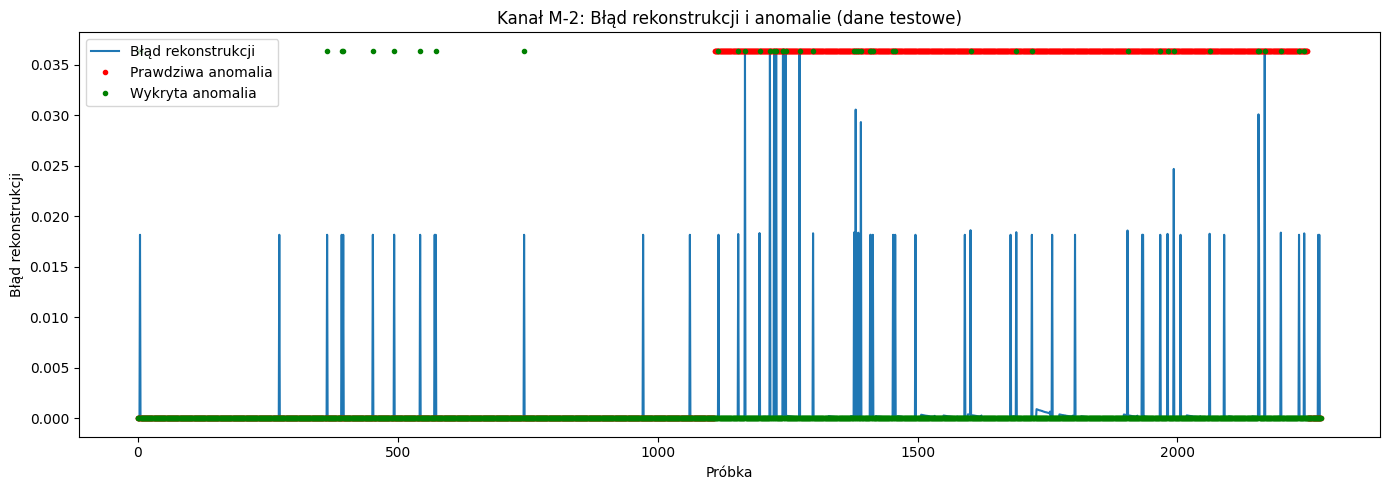

Confusion matrix (test):
[[1127    9]
 [1106   35]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.50      0.99      0.67      1136
     Anomaly       0.80      0.03      0.06      1141

    accuracy                           0.51      2277
   macro avg       0.65      0.51      0.36      2277
weighted avg       0.65      0.51      0.36      2277

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1110, 2250]: WYKRYTA

Czujnik: S-2
Epoch 1/100, Loss: 0.244478
Epoch 21/100, Loss: 0.007786
Epoch 41/100, Loss: 0.001755
Epoch 61/100, Loss: 0.000743
Epoch 81/100, Loss: 0.000706


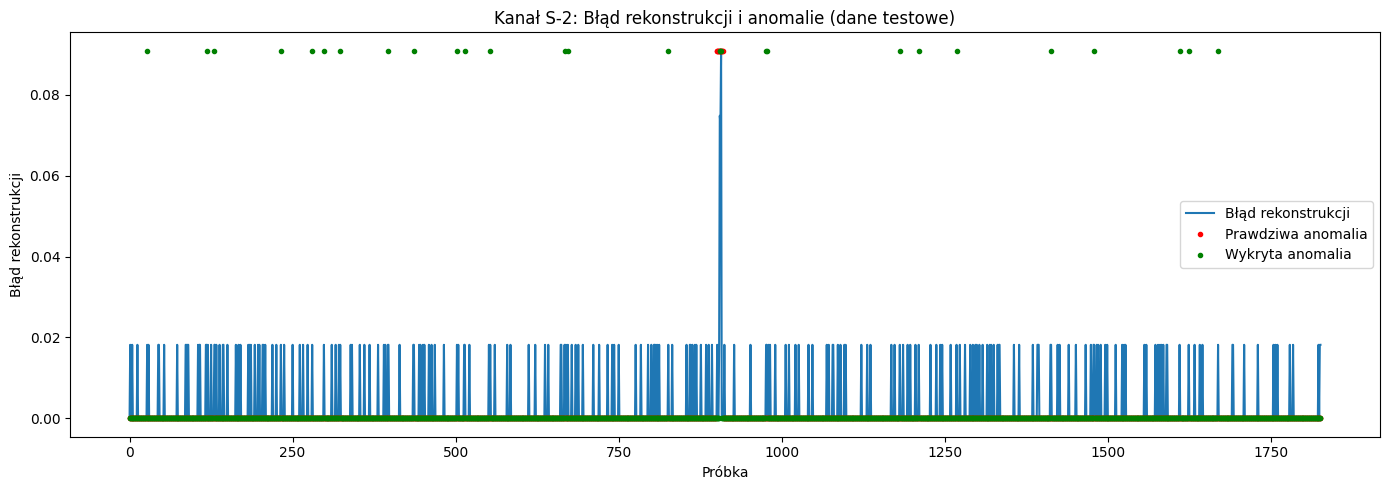

Confusion matrix (test):
[[1791   25]
 [   8    3]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99      1816
     Anomaly       0.11      0.27      0.15        11

    accuracy                           0.98      1827
   macro avg       0.55      0.63      0.57      1827
weighted avg       0.99      0.98      0.99      1827

Wynik sprawdzania anomalii względem metadanych:
Anomalia [900, 910]: WYKRYTA

Czujnik: P-10
Epoch 1/100, Loss: 0.125926
Epoch 21/100, Loss: 0.000498
Epoch 41/100, Loss: 0.000465
Epoch 61/100, Loss: 0.000465
Epoch 81/100, Loss: 0.000456


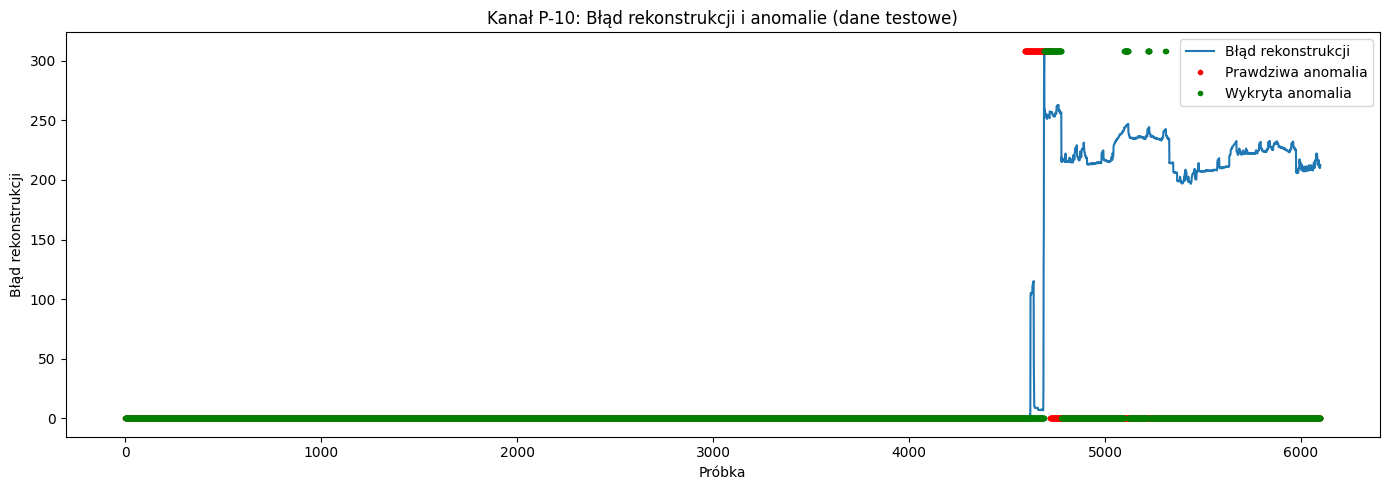

Confusion matrix (test):
[[5879   90]
 [  99   32]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98      5969
     Anomaly       0.26      0.24      0.25       131

    accuracy                           0.97      6100
   macro avg       0.62      0.61      0.62      6100
weighted avg       0.97      0.97      0.97      6100

Wynik sprawdzania anomalii względem metadanych:
Anomalia [4590, 4720]: WYKRYTA

Czujnik: T-4
Epoch 1/100, Loss: 0.212559
Epoch 21/100, Loss: 0.002836
Epoch 41/100, Loss: 0.001575
Epoch 61/100, Loss: 0.001563
Epoch 81/100, Loss: 0.001445


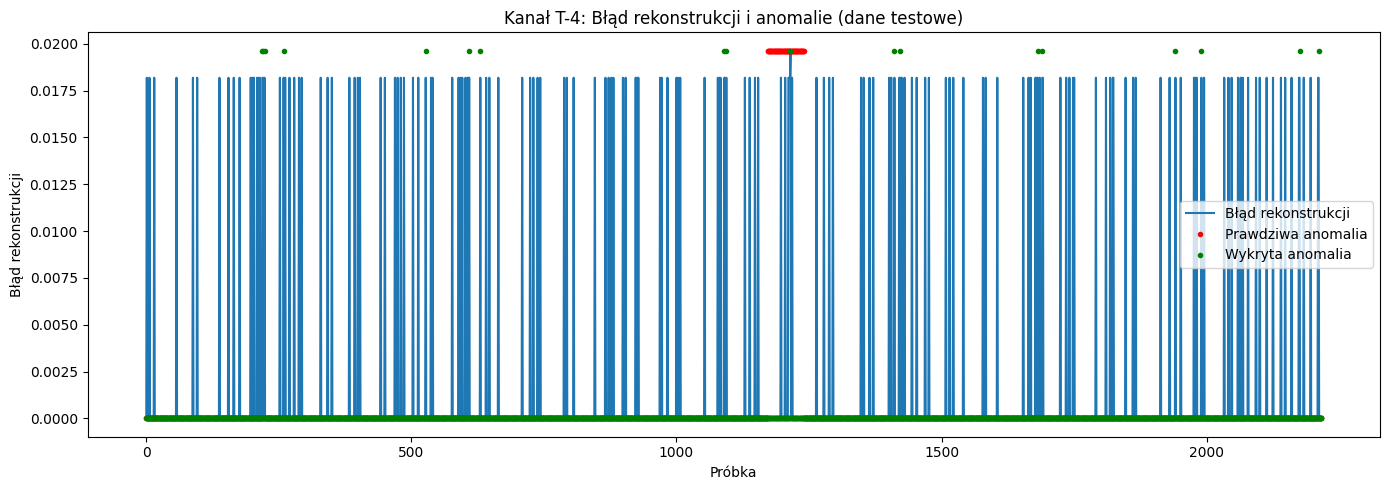

Confusion matrix (test):
[[2131   17]
 [  68    1]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.97      0.99      0.98      2148
     Anomaly       0.06      0.01      0.02        69

    accuracy                           0.96      2217
   macro avg       0.51      0.50      0.50      2217
weighted avg       0.94      0.96      0.95      2217

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1172, 1240]: WYKRYTA

Czujnik: T-5
Epoch 1/100, Loss: 0.206831
Epoch 21/100, Loss: 0.001031
Epoch 41/100, Loss: 0.000326
Epoch 61/100, Loss: 0.000308
Epoch 81/100, Loss: 0.000316


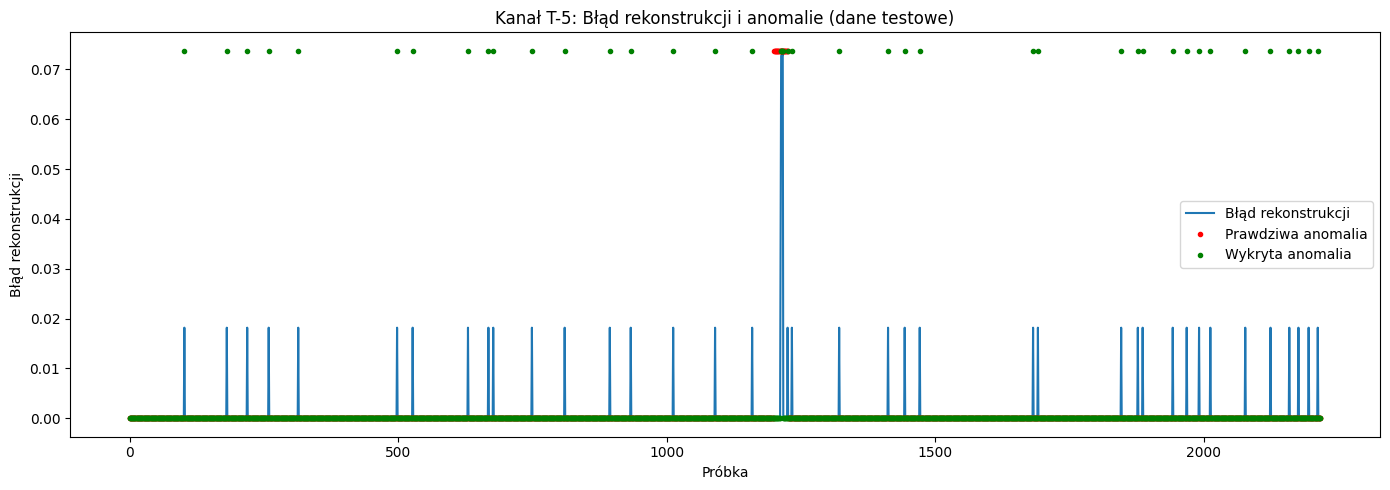

Confusion matrix (test):
[[2155   37]
 [  20    6]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.99      2192
     Anomaly       0.14      0.23      0.17        26

    accuracy                           0.97      2218
   macro avg       0.57      0.61      0.58      2218
weighted avg       0.98      0.97      0.98      2218

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1200, 1225]: WYKRYTA

Czujnik: F-7
Epoch 1/100, Loss: 0.194362
Epoch 21/100, Loss: 0.001614
Epoch 41/100, Loss: 0.001497
Epoch 61/100, Loss: 0.000699
Epoch 81/100, Loss: 0.000743


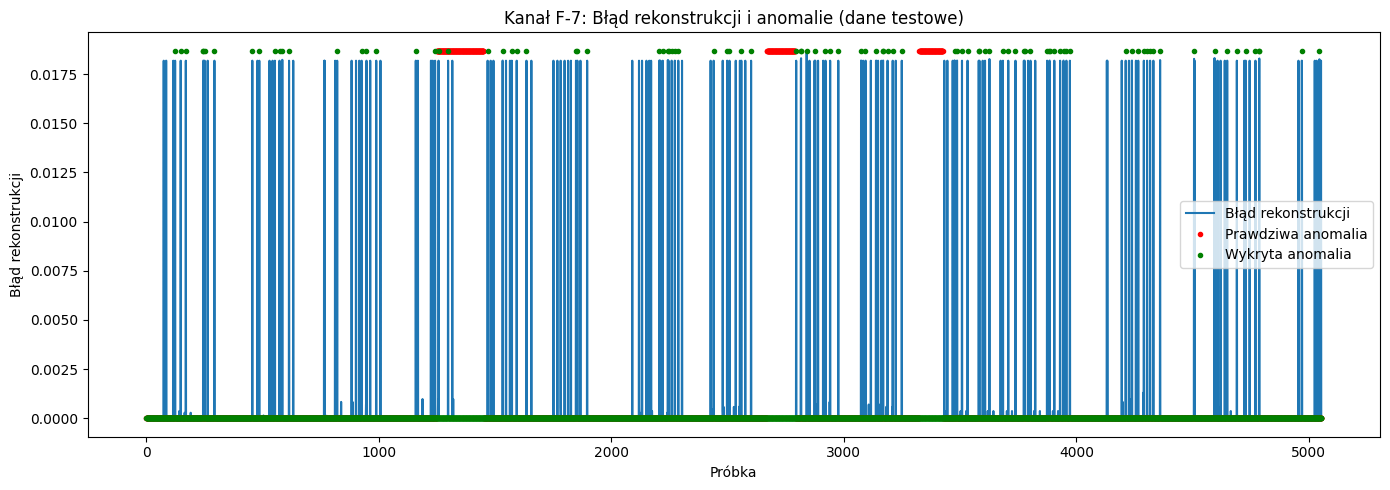

Confusion matrix (test):
[[4536   95]
 [ 421    2]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.92      0.98      0.95      4631
     Anomaly       0.02      0.00      0.01       423

    accuracy                           0.90      5054
   macro avg       0.47      0.49      0.48      5054
weighted avg       0.84      0.90      0.87      5054

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1250, 1450]: WYKRYTA
Anomalia [2670, 2790]: NIEWYKRYTA
Anomalia [3325, 3425]: NIEWYKRYTA

Czujnik: M-3
Epoch 1/100, Loss: 0.220794
Epoch 21/100, Loss: 0.001263
Epoch 41/100, Loss: 0.001195
Epoch 61/100, Loss: 0.000899
Epoch 81/100, Loss: 0.000560


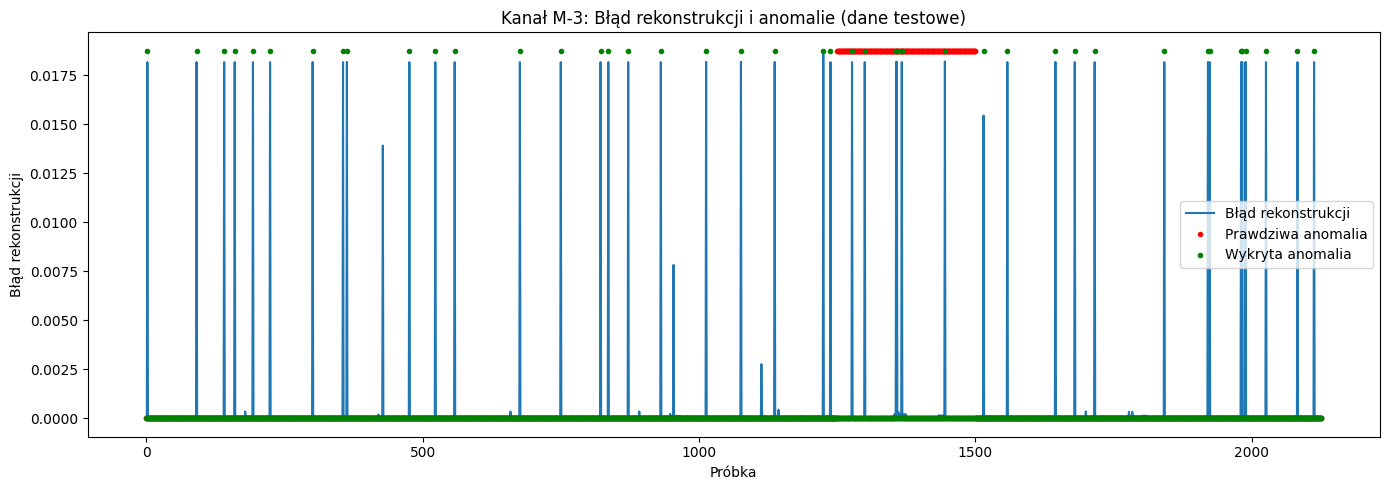

Confusion matrix (test):
[[1839   37]
 [ 245    6]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.88      0.98      0.93      1876
     Anomaly       0.14      0.02      0.04       251

    accuracy                           0.87      2127
   macro avg       0.51      0.50      0.48      2127
weighted avg       0.79      0.87      0.82      2127

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1250, 1500]: WYKRYTA

Czujnik: M-4
Epoch 1/100, Loss: 0.219685
Epoch 21/100, Loss: 0.002480
Epoch 41/100, Loss: 0.001958
Epoch 61/100, Loss: 0.001809
Epoch 81/100, Loss: 0.001607


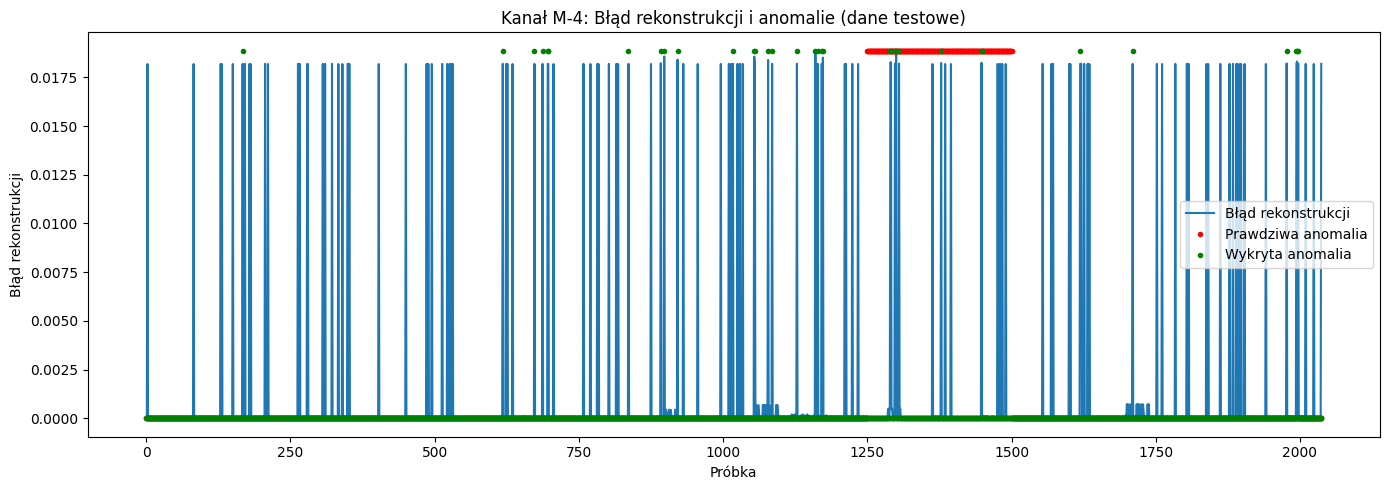

Confusion matrix (test):
[[1761   26]
 [ 244    7]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.88      0.99      0.93      1787
     Anomaly       0.21      0.03      0.05       251

    accuracy                           0.87      2038
   macro avg       0.55      0.51      0.49      2038
weighted avg       0.80      0.87      0.82      2038

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1250, 1500]: WYKRYTA

Czujnik: M-5
Epoch 1/100, Loss: 0.210783
Epoch 21/100, Loss: 0.001397
Epoch 41/100, Loss: 0.000797
Epoch 61/100, Loss: 0.000555
Epoch 81/100, Loss: 0.000543


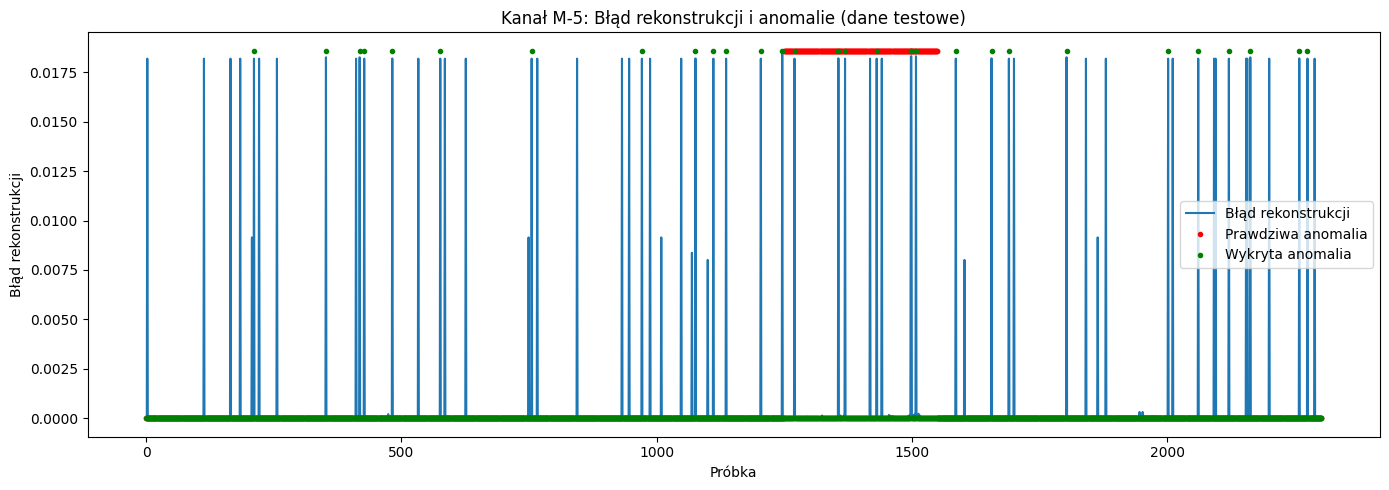

Confusion matrix (test):
[[1979   23]
 [ 294    7]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.87      0.99      0.93      2002
     Anomaly       0.23      0.02      0.04       301

    accuracy                           0.86      2303
   macro avg       0.55      0.51      0.48      2303
weighted avg       0.79      0.86      0.81      2303

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1250, 1550]: WYKRYTA

Czujnik: P-15
Epoch 1/100, Loss: 0.145430
Epoch 21/100, Loss: 0.000978
Epoch 41/100, Loss: 0.000927
Epoch 61/100, Loss: 0.000747
Epoch 81/100, Loss: 0.000753


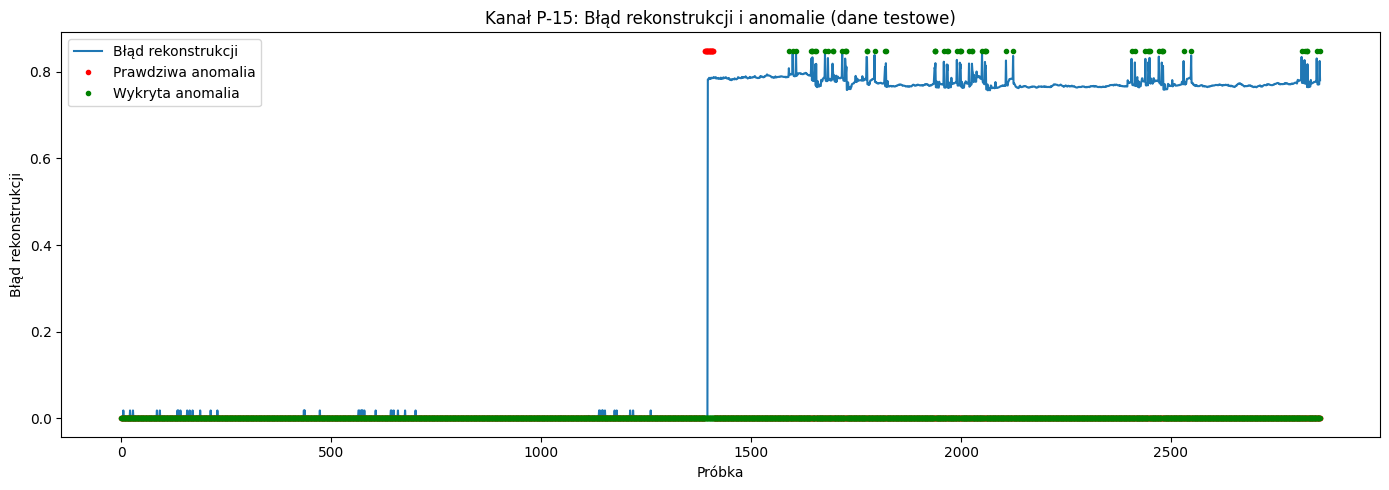

Confusion matrix (test):
[[2777   58]
 [  21    0]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.99      2835
     Anomaly       0.00      0.00      0.00        21

    accuracy                           0.97      2856
   macro avg       0.50      0.49      0.49      2856
weighted avg       0.99      0.97      0.98      2856

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1390, 1410]: NIEWYKRYTA

Czujnik: C-1
Epoch 1/100, Loss: 0.215282
Epoch 21/100, Loss: 0.002478
Epoch 41/100, Loss: 0.000927
Epoch 61/100, Loss: 0.000896
Epoch 81/100, Loss: 0.000537


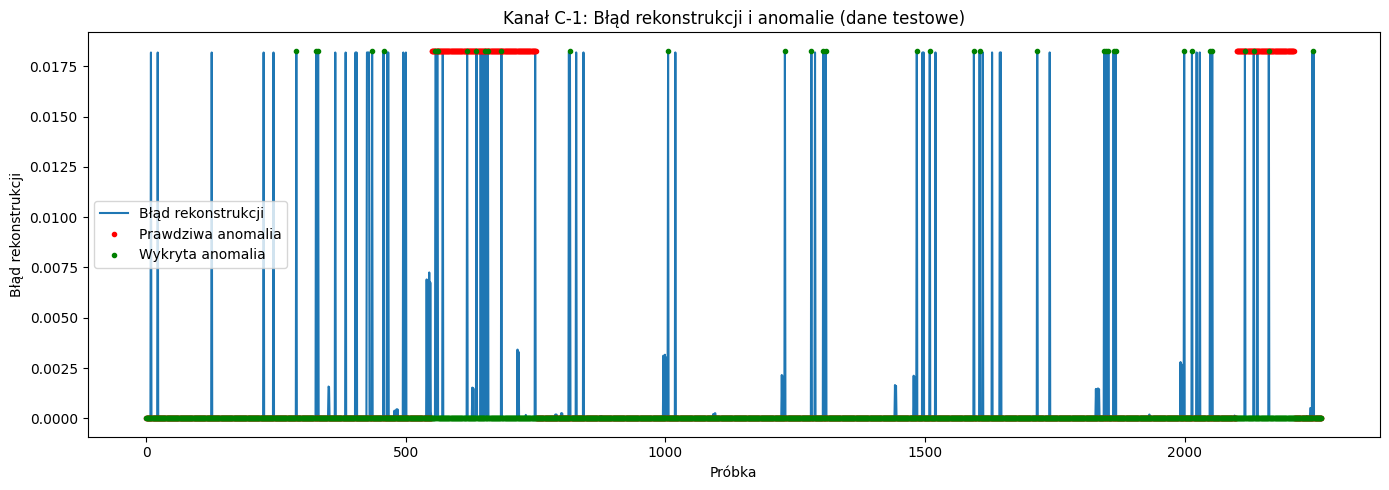

Confusion matrix (test):
[[1926   26]
 [ 301   11]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.86      0.99      0.92      1952
     Anomaly       0.30      0.04      0.06       312

    accuracy                           0.86      2264
   macro avg       0.58      0.51      0.49      2264
weighted avg       0.79      0.86      0.80      2264

Wynik sprawdzania anomalii względem metadanych:
Anomalia [550, 750]: WYKRYTA
Anomalia [2100, 2210]: WYKRYTA

Czujnik: C-2
Epoch 1/100, Loss: 0.242491
Epoch 21/100, Loss: 0.008906
Epoch 41/100, Loss: 0.002989
Epoch 61/100, Loss: 0.002037
Epoch 81/100, Loss: 0.002032


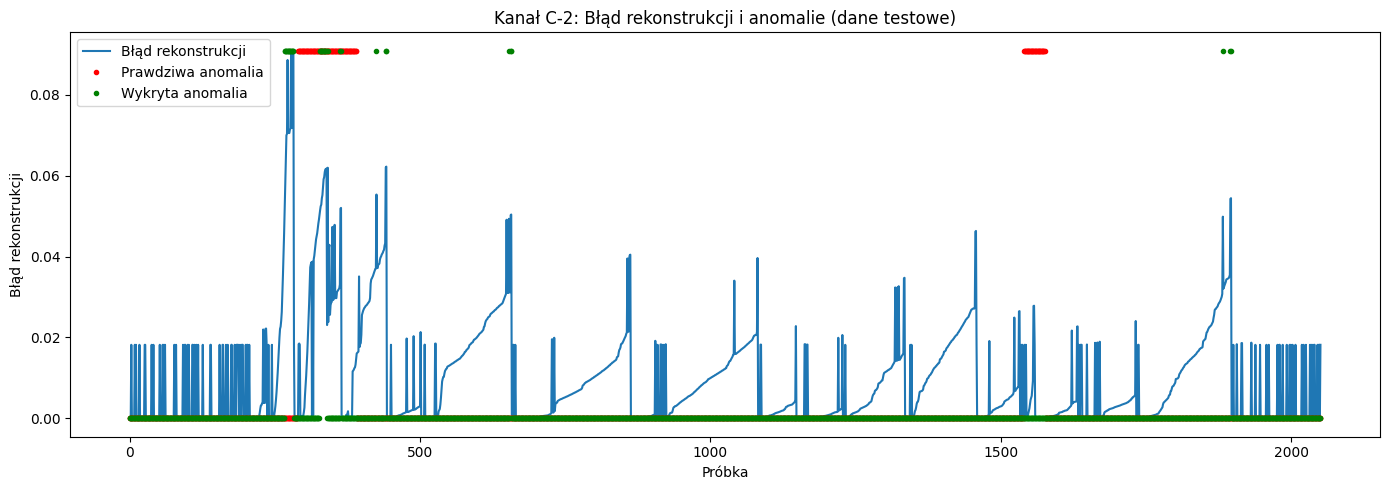

Confusion matrix (test):
[[1889   25]
 [ 121   16]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.94      0.99      0.96      1914
     Anomaly       0.39      0.12      0.18       137

    accuracy                           0.93      2051
   macro avg       0.67      0.55      0.57      2051
weighted avg       0.90      0.93      0.91      2051

Wynik sprawdzania anomalii względem metadanych:
Anomalia [290, 390]: WYKRYTA
Anomalia [1540, 1575]: NIEWYKRYTA

Czujnik: T-12
Epoch 1/100, Loss: 0.237814
Epoch 21/100, Loss: 0.001517
Epoch 41/100, Loss: 0.000866
Epoch 61/100, Loss: 0.000829
Epoch 81/100, Loss: 0.000600


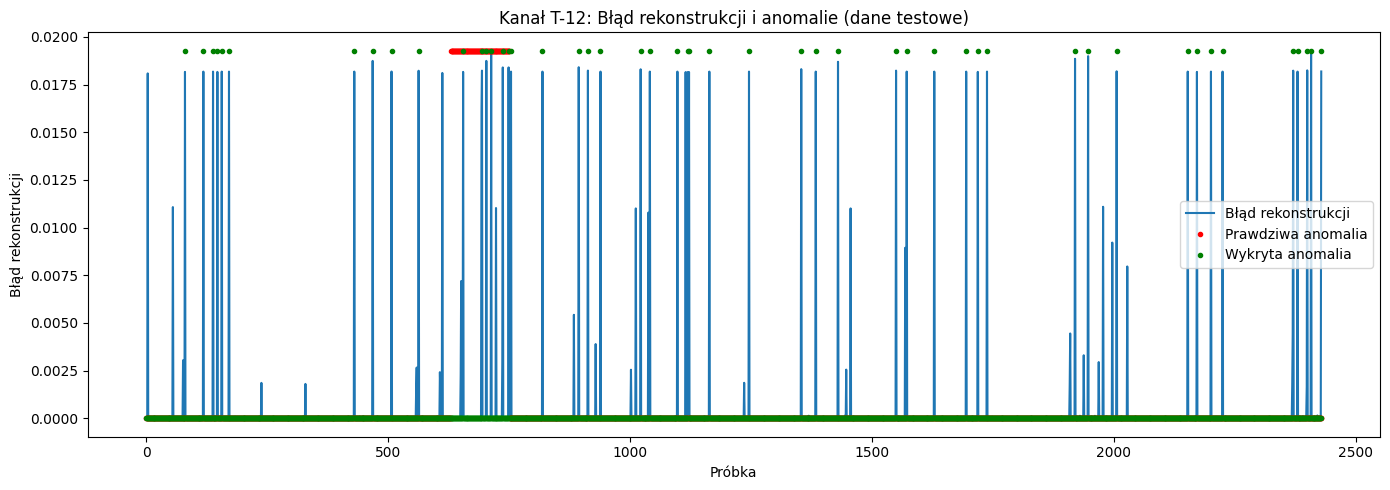

Confusion matrix (test):
[[2266   43]
 [ 115    6]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.95      0.98      0.97      2309
     Anomaly       0.12      0.05      0.07       121

    accuracy                           0.93      2430
   macro avg       0.54      0.52      0.52      2430
weighted avg       0.91      0.93      0.92      2430

Wynik sprawdzania anomalii względem metadanych:
Anomalia [630, 750]: WYKRYTA

Czujnik: T-13
Epoch 1/100, Loss: 0.236536
Epoch 21/100, Loss: 0.001306
Epoch 41/100, Loss: 0.000856
Epoch 61/100, Loss: 0.000621
Epoch 81/100, Loss: 0.000446


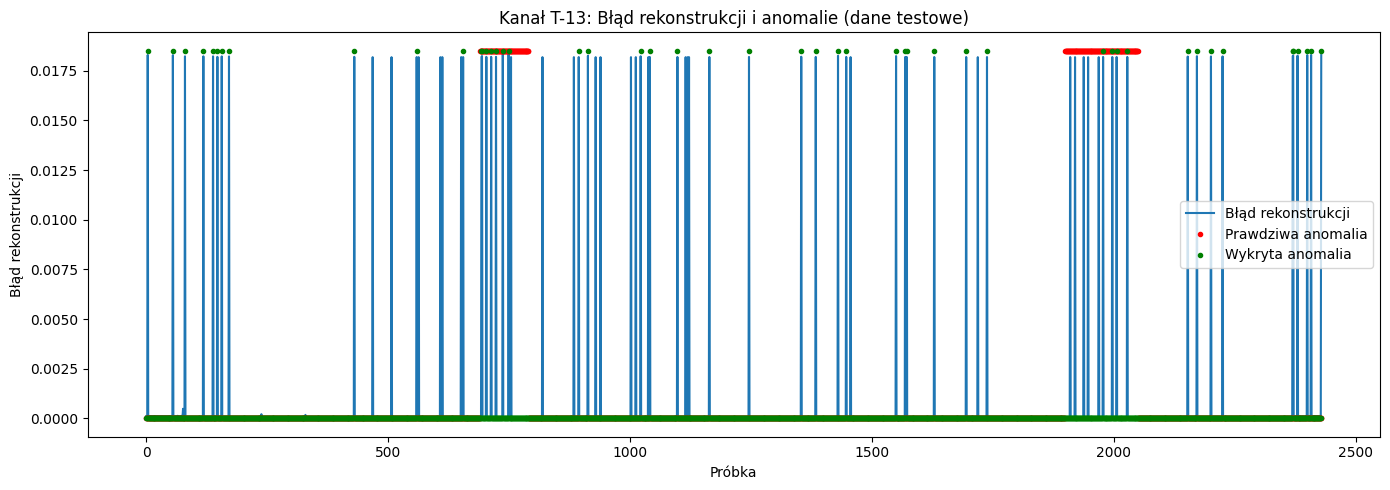

Confusion matrix (test):
[[2140   38]
 [ 241   11]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.90      0.98      0.94      2178
     Anomaly       0.22      0.04      0.07       252

    accuracy                           0.89      2430
   macro avg       0.56      0.51      0.51      2430
weighted avg       0.83      0.89      0.85      2430

Wynik sprawdzania anomalii względem metadanych:
Anomalia [690, 790]: WYKRYTA
Anomalia [1900, 2050]: WYKRYTA

Czujnik: F-4
Epoch 1/100, Loss: 0.214479
Epoch 21/100, Loss: 0.001914
Epoch 41/100, Loss: 0.000773
Epoch 61/100, Loss: 0.000376
Epoch 81/100, Loss: 0.000375


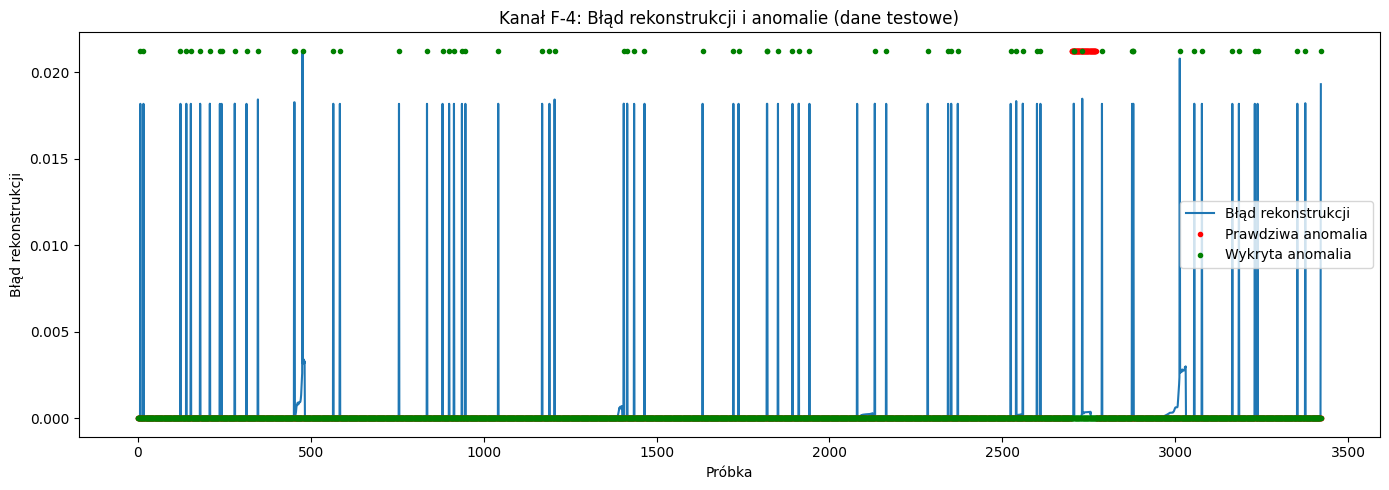

Confusion matrix (test):
[[3285   66]
 [  68    3]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98      3351
     Anomaly       0.04      0.04      0.04        71

    accuracy                           0.96      3422
   macro avg       0.51      0.51      0.51      3422
weighted avg       0.96      0.96      0.96      3422

Wynik sprawdzania anomalii względem metadanych:
Anomalia [2700, 2770]: WYKRYTA

Czujnik: F-5
Epoch 1/100, Loss: 0.197448
Epoch 21/100, Loss: 0.000811
Epoch 41/100, Loss: 0.000359
Epoch 61/100, Loss: 0.000348
Epoch 81/100, Loss: 0.000357


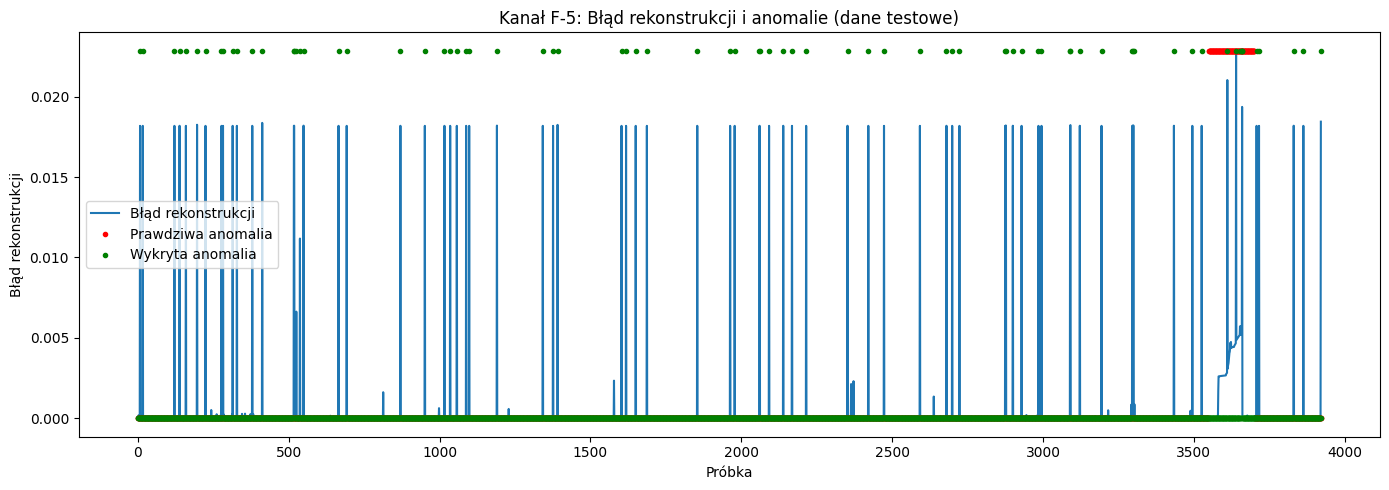

Confusion matrix (test):
[[3699   72]
 [ 144    7]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97      3771
     Anomaly       0.09      0.05      0.06       151

    accuracy                           0.94      3922
   macro avg       0.53      0.51      0.52      3922
weighted avg       0.93      0.94      0.94      3922

Wynik sprawdzania anomalii względem metadanych:
Anomalia [3550, 3700]: WYKRYTA

Czujnik: D-14
Epoch 1/100, Loss: 0.149089
Epoch 21/100, Loss: 0.000340
Epoch 41/100, Loss: 0.000333
Epoch 61/100, Loss: 0.000353
Epoch 81/100, Loss: 0.000219


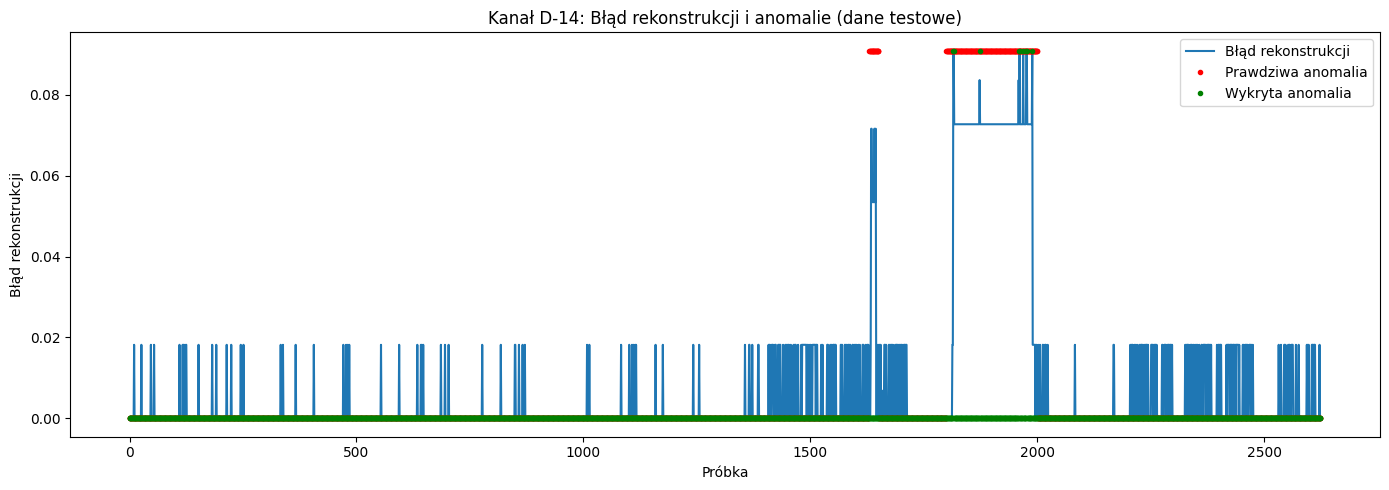

Confusion matrix (test):
[[2403    0]
 [ 213    9]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.92      1.00      0.96      2403
     Anomaly       1.00      0.04      0.08       222

    accuracy                           0.92      2625
   macro avg       0.96      0.52      0.52      2625
weighted avg       0.93      0.92      0.88      2625

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1630, 1650]: NIEWYKRYTA
Anomalia [1800, 2000]: WYKRYTA

Czujnik: T-9
Epoch 1/100, Loss: 0.243748
Epoch 21/100, Loss: 0.008530
Epoch 41/100, Loss: 0.001689
Epoch 61/100, Loss: 0.001410
Epoch 81/100, Loss: 0.001411


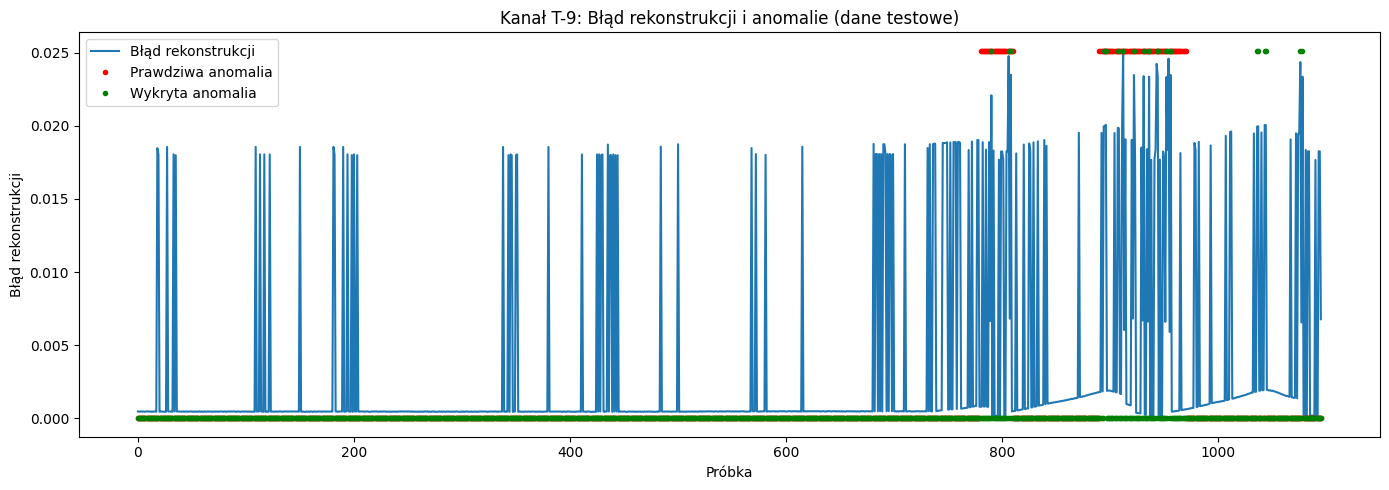

Confusion matrix (test):
[[978   6]
 [ 96  16]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.91      0.99      0.95       984
     Anomaly       0.73      0.14      0.24       112

    accuracy                           0.91      1096
   macro avg       0.82      0.57      0.59      1096
weighted avg       0.89      0.91      0.88      1096

Wynik sprawdzania anomalii względem metadanych:
Anomalia [780, 810]: WYKRYTA
Anomalia [890, 970]: WYKRYTA

Czujnik: P-14
Epoch 1/100, Loss: 0.195166
Epoch 21/100, Loss: 0.000536
Epoch 41/100, Loss: 0.000411
Epoch 61/100, Loss: 0.000411
Epoch 81/100, Loss: 0.000411


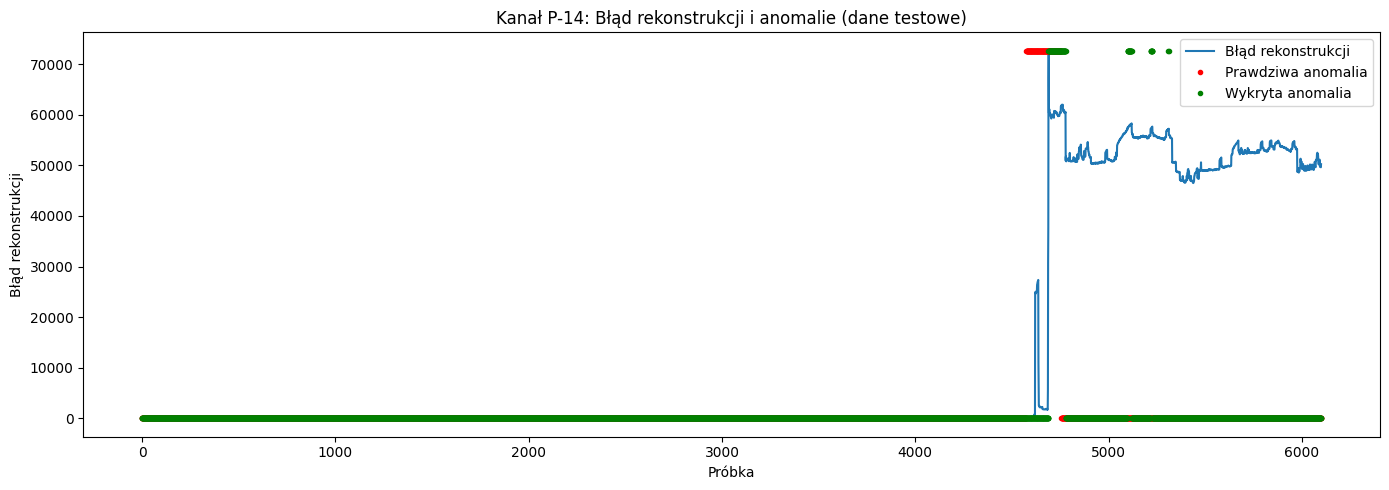

Confusion matrix (test):
[[5864   55]
 [ 114   67]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.99      5919
     Anomaly       0.55      0.37      0.44       181

    accuracy                           0.97      6100
   macro avg       0.77      0.68      0.71      6100
weighted avg       0.97      0.97      0.97      6100

Wynik sprawdzania anomalii względem metadanych:
Anomalia [4575, 4755]: WYKRYTA

Czujnik: T-8
Epoch 1/100, Loss: 0.235537
Epoch 21/100, Loss: 0.007263
Epoch 41/100, Loss: 0.001020
Epoch 61/100, Loss: 0.000994
Epoch 81/100, Loss: 0.000952


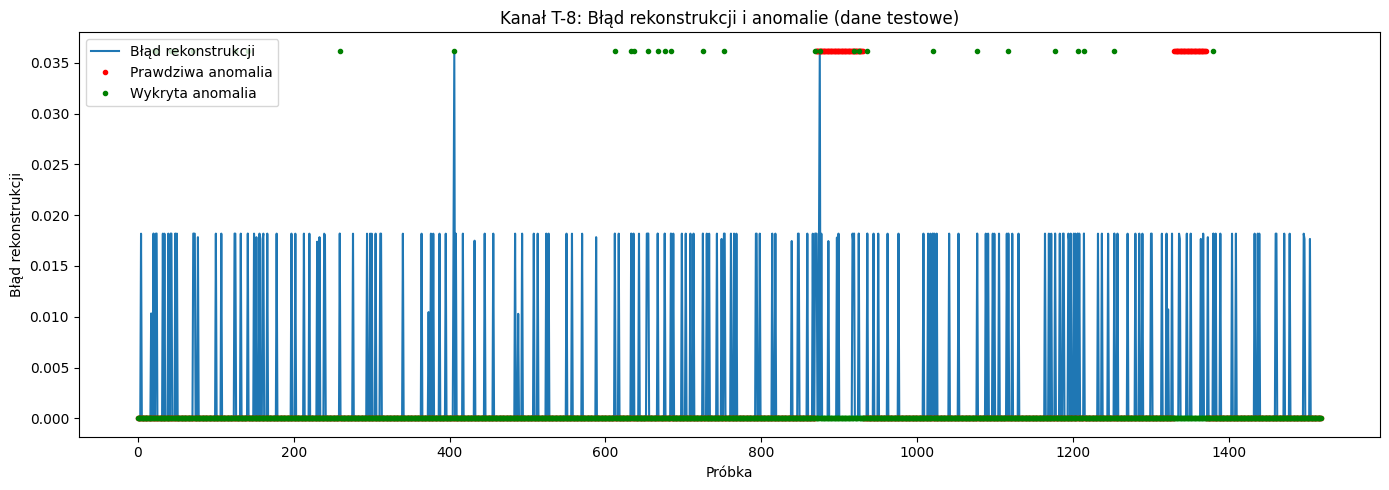

Confusion matrix (test):
[[1389   28]
 [  99    3]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.93      0.98      0.96      1417
     Anomaly       0.10      0.03      0.05       102

    accuracy                           0.92      1519
   macro avg       0.52      0.50      0.50      1519
weighted avg       0.88      0.92      0.90      1519

Wynik sprawdzania anomalii względem metadanych:
Anomalia [870, 930]: WYKRYTA
Anomalia [1330, 1370]: NIEWYKRYTA

Czujnik: P-11
Epoch 1/100, Loss: 0.142996
Epoch 21/100, Loss: 0.001056
Epoch 41/100, Loss: 0.001028
Epoch 61/100, Loss: 0.001025
Epoch 81/100, Loss: 0.000949


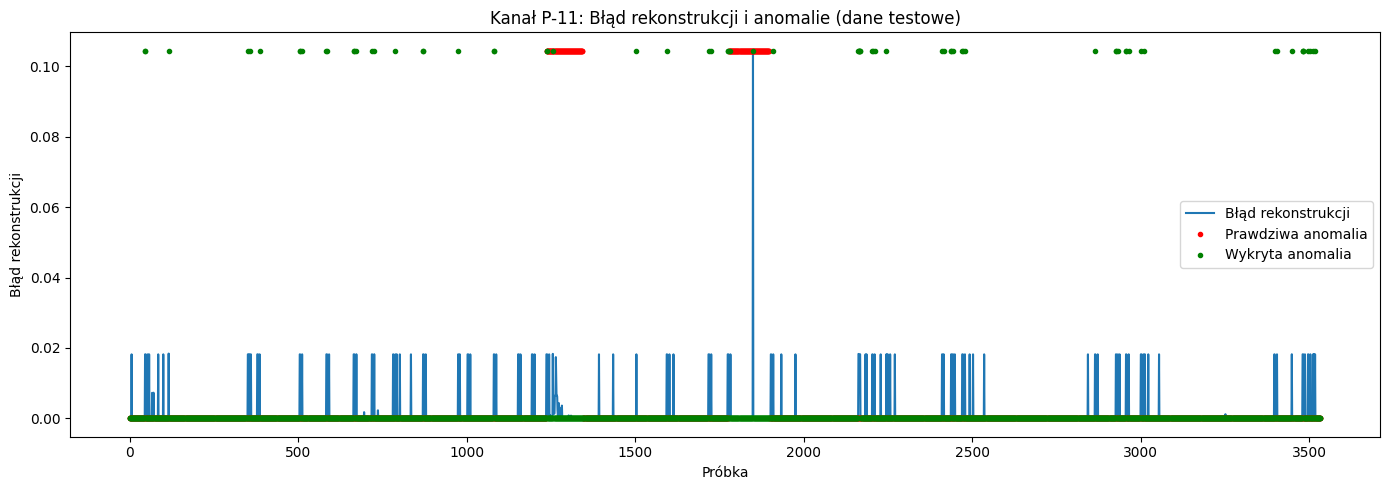

Confusion matrix (test):
[[3241   66]
 [ 223    5]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.94      0.98      0.96      3307
     Anomaly       0.07      0.02      0.03       228

    accuracy                           0.92      3535
   macro avg       0.50      0.50      0.50      3535
weighted avg       0.88      0.92      0.90      3535

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1778, 1898]: WYKRYTA
Anomalia [1238, 1344]: WYKRYTA

Czujnik: D-15
Epoch 1/100, Loss: 0.220893
Epoch 21/100, Loss: 0.002594
Epoch 41/100, Loss: 0.002214
Epoch 61/100, Loss: 0.002196
Epoch 81/100, Loss: 0.002170


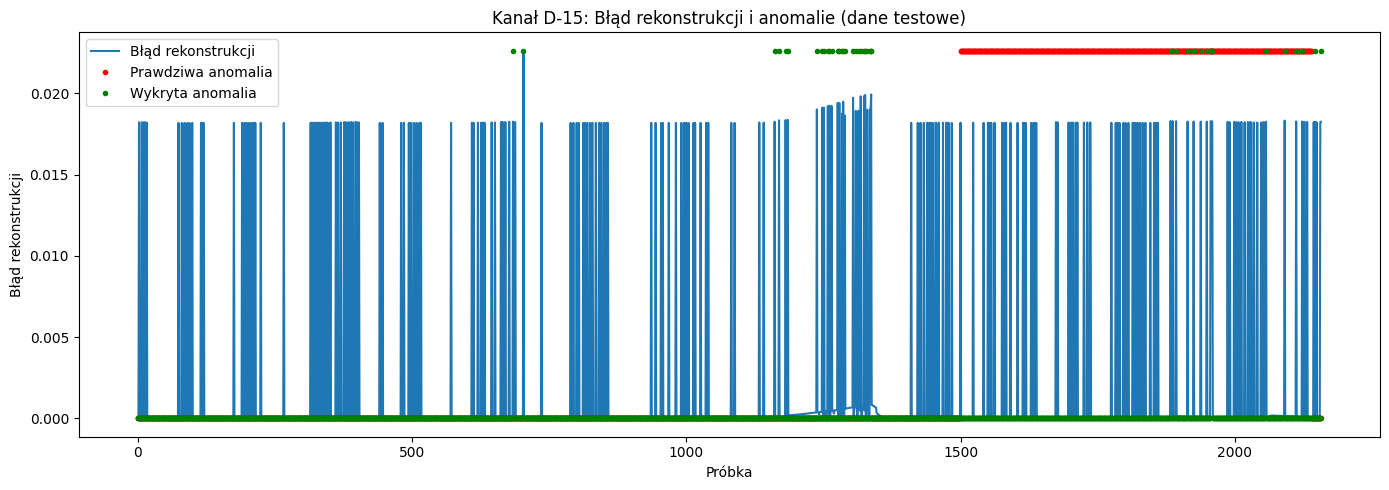

Confusion matrix (test):
[[1488   29]
 [ 626   15]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.70      0.98      0.82      1517
     Anomaly       0.34      0.02      0.04       641

    accuracy                           0.70      2158
   macro avg       0.52      0.50      0.43      2158
weighted avg       0.60      0.70      0.59      2158

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1500, 2140]: WYKRYTA

Czujnik: D-16
Epoch 1/100, Loss: 0.242642
Epoch 21/100, Loss: 0.002719
Epoch 41/100, Loss: 0.001464
Epoch 61/100, Loss: 0.000943
Epoch 81/100, Loss: 0.000786


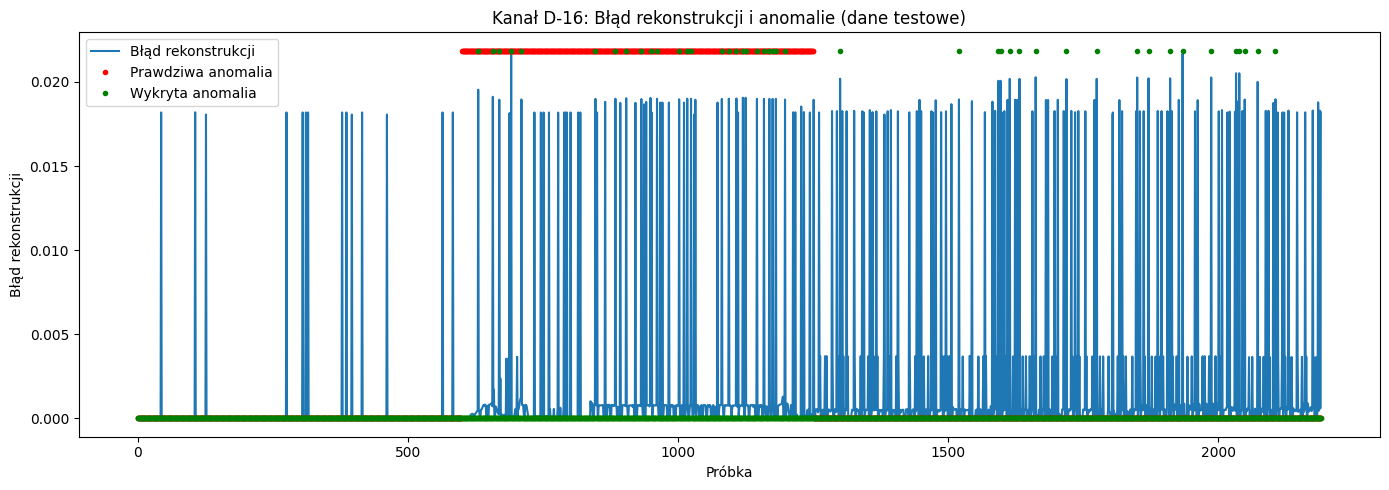

Confusion matrix (test):
[[1521   19]
 [ 626   25]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.71      0.99      0.83      1540
     Anomaly       0.57      0.04      0.07       651

    accuracy                           0.71      2191
   macro avg       0.64      0.51      0.45      2191
weighted avg       0.67      0.71      0.60      2191

Wynik sprawdzania anomalii względem metadanych:
Anomalia [600, 1250]: WYKRYTA

Czujnik: M-7
Epoch 1/100, Loss: 0.229194
Epoch 21/100, Loss: 0.003097
Epoch 41/100, Loss: 0.001390
Epoch 61/100, Loss: 0.001329
Epoch 81/100, Loss: 0.001336


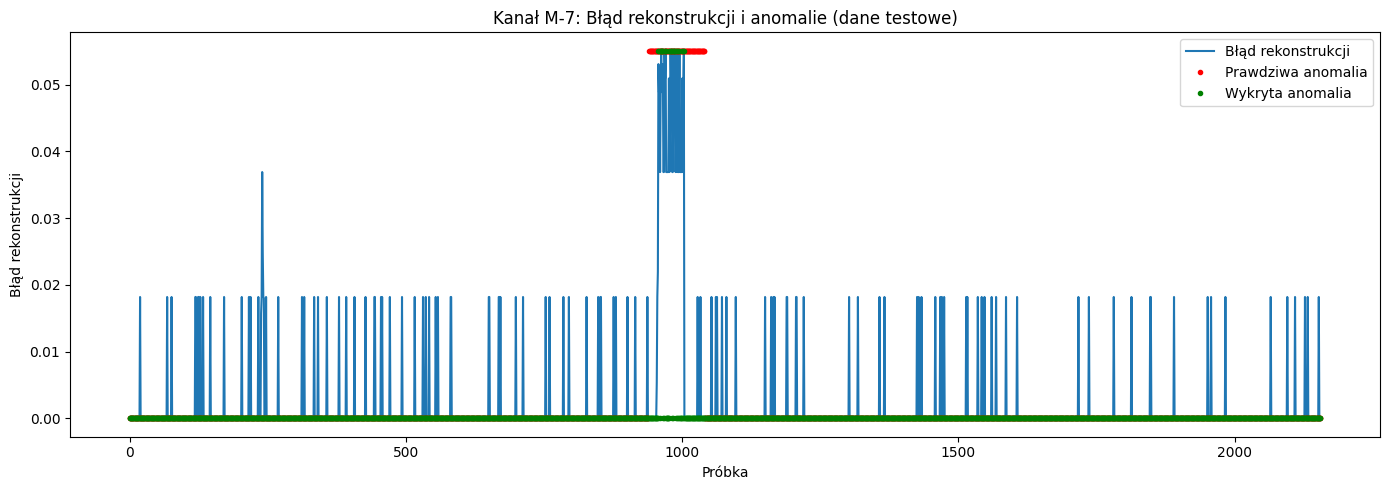

Confusion matrix (test):
[[2055    0]
 [  74   27]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.97      1.00      0.98      2055
     Anomaly       1.00      0.27      0.42       101

    accuracy                           0.97      2156
   macro avg       0.98      0.63      0.70      2156
weighted avg       0.97      0.97      0.96      2156

Wynik sprawdzania anomalii względem metadanych:
Anomalia [940, 1040]: WYKRYTA

Czujnik: F-8
Epoch 1/100, Loss: 0.174614
Epoch 21/100, Loss: 0.000586
Epoch 41/100, Loss: 0.000367
Epoch 61/100, Loss: 0.000361
Epoch 81/100, Loss: 0.000360


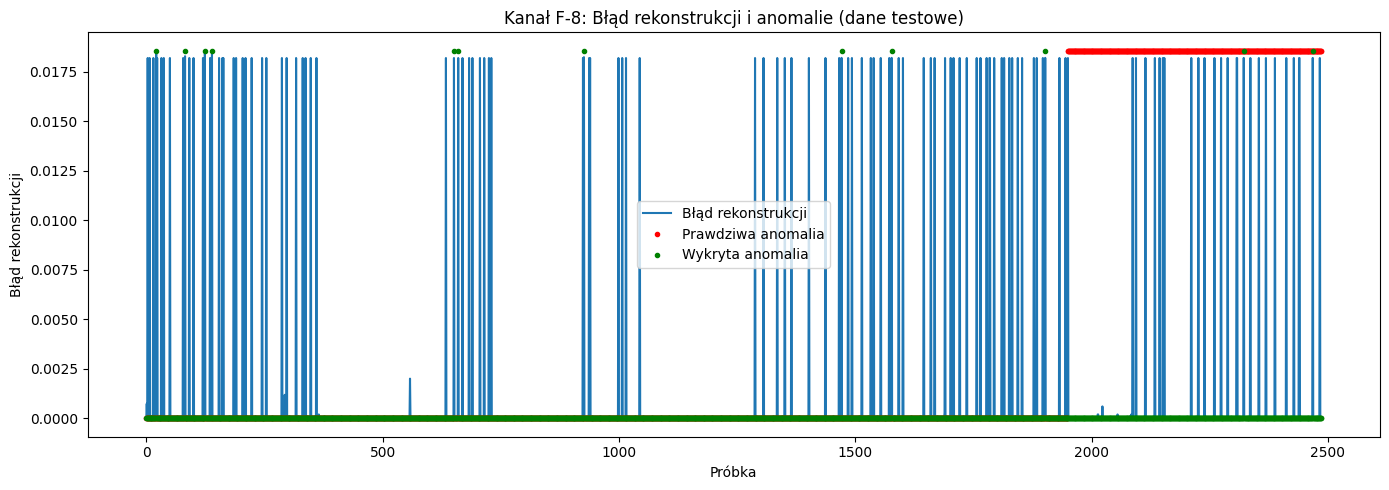

Confusion matrix (test):
[[1940   10]
 [ 535    2]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.78      0.99      0.88      1950
     Anomaly       0.17      0.00      0.01       537

    accuracy                           0.78      2487
   macro avg       0.48      0.50      0.44      2487
weighted avg       0.65      0.78      0.69      2487

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1950, 2486]: WYKRYTA


In [58]:
# Parametry do ustawienia
batch_size = 64
epochs = 100
threshold_percentile = 98

from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Definicja modelu
class UniversalAE(nn.Module):
    def __init__(self, input_dim):
        super(UniversalAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Pętla po wszystkich czujnikach
for sensor_name in msl_channels:
    print(f"\n{'='*40}\nCzujnik: {sensor_name}\n{'='*40}")

    # Przygotowanie danych treningowych i testowych
    sensor_train_data = msl_train_data[sensor_name]
    sensor_test_data = msl_test_data[sensor_name]
    input_dim = sensor_train_data.shape[1]

    scaler = MinMaxScaler()
    arr_norm = scaler.fit_transform(sensor_train_data)
    arr_test_norm = scaler.transform(sensor_test_data)

    # Nauka modelu
    model = UniversalAE(input_dim).to(device)
    X_train = torch.tensor(arr_norm, dtype=torch.float32).to(device)
    train_dataset = TensorDataset(X_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            x_batch = batch[0]
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, x_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % max(epochs // 5, 1) == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.6f}")

    # Testowanie modelu
    X_test = torch.tensor(arr_test_norm, dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        recon = model(X_test).cpu().numpy()
    recon_error = np.mean((arr_test_norm - recon) ** 2, axis=1)

    # Wykrywanie anomalii
    threshold = np.percentile(recon_error, threshold_percentile)
    predicted_anomaly = (recon_error > threshold).astype(int)

    # Prawdziwe anomalie z labeled_anomalies.csv
    anomaly_row = metadata[metadata['chan_id'] == sensor_name]
    anomaly_sequences = []
    if not anomaly_row.empty:
        anomaly_sequences = eval(anomaly_row.iloc[0]['anomaly_sequences'])

    true_anomaly = np.zeros(len(recon_error), dtype=int)
    for seq in anomaly_sequences:
        start, end = seq
        true_anomaly[start:min(end+1, len(true_anomaly))] = 1

    # Wizualizacja wyników
    plt.figure(figsize=(14, 5))
    plt.plot(recon_error, label="Błąd rekonstrukcji")
    plt.plot(true_anomaly * np.max(recon_error), 'r.', label="Prawdziwa anomalia")
    plt.plot(predicted_anomaly * np.max(recon_error), 'g.', label="Wykryta anomalia")
    plt.title(f"Kanał {sensor_name}: Błąd rekonstrukcji i anomalie (dane testowe)")
    plt.xlabel("Próbka")
    plt.ylabel("Błąd rekonstrukcji")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("Confusion matrix (test):")
    print(confusion_matrix(true_anomaly, predicted_anomaly))
    print("\nClassification report (test):")
    print(classification_report(true_anomaly, predicted_anomaly, target_names=["Normal", "Anomaly"]))

    # Sprawdzenie czy wykryto PRZYNAJMNIEJ JEDNĄ próbkę z każdej zdefiniowanej anomalii
    detected_ranges = []
    for seq in anomaly_sequences:
        start, end = seq
        if np.any(predicted_anomaly[start:min(end+1, len(predicted_anomaly))] == 1):
            detected_ranges.append(seq)

    print("Wynik sprawdzania anomalii względem metadanych:")
    for seq in anomaly_sequences:
        if seq in detected_ranges:
            print(f"Anomalia {seq}: WYKRYTA")
        else:
            print(f"Anomalia {seq}: NIEWYKRYTA")